# Minalyze: Geochemistry

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/OOLDEA2_1m_intervals.csv')

In [21]:
df.tail()

,id,result_master_id,DDH_name,from_m,to_m,Sample_Length_m,Scan_Length_m,Scan_Recovery_pct,Comp(c/s),Rayl(c/s),...,Ce_ppm,Ce_2SE_ppm,Ce_mdl_ppm,Pb_pct,Pb_2SE_pct,Pb_mdl_pct,U_ppm,U_2SE_ppm,U_mdl_ppm,minaloggerlink
151,69383,38,OOLDEA2,164,165,1,0.9415,94.15,1656.487,520.2108,...,189.02,22.34,23.80,0.0,0.0011,0.0017,20.35,9.04,12.86,https://minalogger.com/viewer/?project=WESTERN...
152,69384,38,OOLDEA2,165,166,1,0.8726,87.26,1544.148,524.4318,...,211.75,23.87,25.67,0.0,0.0000,0.0000,19.08,9.80,14.40,https://minalogger.com/viewer/?project=WESTERN...
153,69385,38,OOLDEA2,166,167,1,0.7751,77.51,1957.022,561.2939,...,117.73,25.62,26.52,0.0,0.0013,0.0019,32.09,10.72,15.23,https://minalogger.com/viewer/?project=WESTERN...
154,69386,38,OOLDEA2,167,168,1,0.8018,80.18,1702.285,545.7176,...,212.74,25.77,27.18,0.0,0.0013,0.0019,21.36,10.30,15.11,https://minalogger.com/viewer/?project=WESTERN...
155,69387,38,OOLDEA2,168,169,1,0.7051,70.51,1184.426,468.7084,...,199.32,25.92,28.52,0.0,0.0000,0.0000,0.00,11.65,17.69,https://minalogger.com/viewer/?project=WESTERN...


In [5]:
df.columns

Index(['id', 'result_master_id', 'DDH_name', 'from_m', 'to_m',
       'Sample_Length_m', 'Scan_Length_m', 'Scan_Recovery_pct', 'Comp(c/s)',
       'Rayl(c/s)', 'LT(secs)', 'Al_pct', 'Al_2SE_pct', 'Al_mdl_pct', 'Si_pct',
       'Si_2SE_pct', 'Si_mdl_pct', 'P_ppm', 'P_2SE_ppm', 'P_mdl_ppm', 'S_pct',
       'S_2SE_pct', 'S_mdl_pct', 'Cl_ppm', 'Cl_2SE_ppm', 'Cl_mdl_ppm', 'K_pct',
       'K_2SE_pct', 'K_mdl_pct', 'Ca_pct', 'Ca_2SE_pct', 'Ca_mdl_pct',
       'Ti_ppm', 'Ti_2SE_ppm', 'Ti_mdl_ppm', 'V_ppm', 'V_2SE_ppm', 'V_mdl_ppm',
       'Cr_ppm', 'Cr_2SE_ppm', 'Cr_mdl_ppm', 'Mn_ppm', 'Mn_2SE_ppm',
       'Mn_mdl_ppm', 'Fe_pct', 'Fe_2SE_pct', 'Fe_mdl_pct', 'Ni_ppm',
       'Ni_2SE_ppm', 'Ni_mdl_ppm', 'Cu_pct', 'Cu_2SE_pct', 'Cu_mdl_pct',
       'Zn_pct', 'Zn_2SE_pct', 'Zn_mdl_pct', 'Ga_ppm', 'Ga_2SE_ppm',
       'Ga_mdl_ppm', 'As_ppm', 'As_2SE_ppm', 'As_mdl_ppm', 'Se_ppm',
       'Se_2SE_ppm', 'Se_mdl_ppm', 'Rb_ppm', 'Rb_2SE_ppm', 'Rb_mdl_ppm',
       'Sr_ppm', 'Sr_2SE_ppm', 'Sr_mdl_ppm', 'Y_

In [6]:
var_str = list( df.columns )

features = ([i for i, s in enumerate(var_str) if "pct"   in s] + 
    [i for i, s in enumerate(var_str) if "ppm"   in s])

df_features = df.iloc[:,features[1:]]

df_features.head()


,Al_pct,Al_2SE_pct,Al_mdl_pct,Si_pct,Si_2SE_pct,Si_mdl_pct,S_pct,S_2SE_pct,S_mdl_pct,K_pct,...,Ba_mdl_ppm,La_ppm,La_2SE_ppm,La_mdl_ppm,Ce_ppm,Ce_2SE_ppm,Ce_mdl_ppm,U_ppm,U_2SE_ppm,U_mdl_ppm
0,2.4882,0.6711,0.8397,22.3157,0.7263,0.2942,0.3293,0.0857,0.0857,2.1815,...,75.76,144.19,88.37,35.04,87.31,54.90,40.99,22.97,15.03,20.40
1,5.4625,0.6962,0.5558,23.3913,0.6344,0.2257,1.5906,0.2473,0.0677,2.0354,...,69.75,98.25,69.88,31.75,70.23,45.22,36.78,20.18,12.16,16.75
2,2.9798,0.5095,0.5622,23.6034,0.5939,0.2036,1.0650,0.1690,0.0604,2.4316,...,56.96,88.25,56.43,26.37,113.00,36.45,30.90,31.67,10.89,14.70
3,4.0648,0.5209,0.4220,19.1905,0.5057,0.1687,0.0773,0.0377,0.0505,1.8808,...,45.81,57.82,45.34,21.19,73.96,29.13,24.85,24.23,9.12,12.22
4,3.4820,0.5105,0.4811,15.7049,0.4627,0.1896,0.2257,0.0546,0.0538,2.0808,...,48.86,0.00,42.79,22.57,94.63,28.67,26.67,22.88,10.39,13.37


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#pca = PCA(n_components = 3)
#X = pca.fit_transform(df_features)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=10))])
X=pipeline.fit_transform(df_features)

In [8]:
def plot_pca(X, mode="2D"):

    if mode.lower() == "2d":

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, aspect='equal')

        ax.scatter(X[:, 0], X[:, 1], alpha=.5, s=60)

        ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
        ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
        ax.set_xlabel("$pca_1$", fontsize=18)
        ax.set_ylabel("$pca_2$", fontsize=18)
        ax.grid(True)

    elif mode.lower() == "3d":

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X[:, 0], X[:, 1],  X[:, 2],  alpha=.4, s=60)
        ax.view_init(25, -50)

        ax.set_xlabel("$pca_1$", fontsize=18)
        ax.set_ylabel("$pca_2$", fontsize=18)
        ax.set_zlabel("$pca_3$", fontsize=18)
        ax.grid(True)

    else:

        print('Unknown mode: please specify as 2D or 3D')


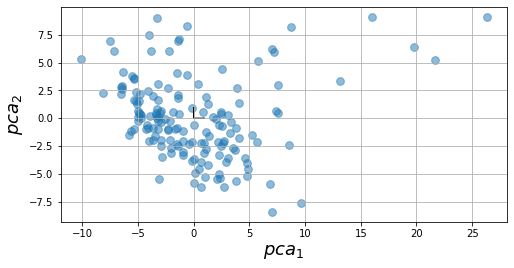

In [9]:
plot_pca( X )


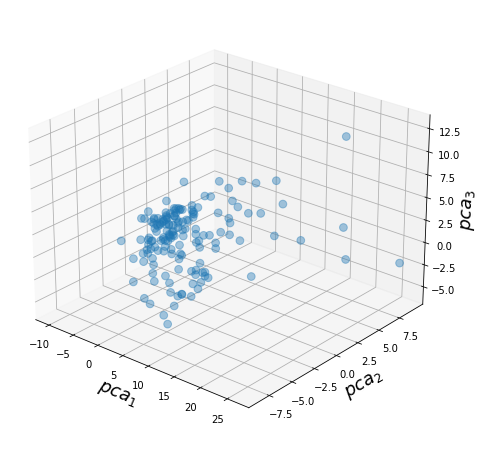

In [10]:
plot_pca( X, mode="3D")

## K-Means

In [11]:
from sklearn.cluster import KMeans

In [12]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
                
inertias = [model.inertia_ for model in kmeans_per_k]

In [13]:
def  elbow_plot(inertias):
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(1, len(inertias)+1), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    plt.annotate('Elbow',
                xy=(3, inertias[2]),
                xytext=(0.55, 0.55),
                textcoords='figure fraction',
                fontsize=16,
                arrowprops=dict(facecolor='black', shrink=0.1)
                )

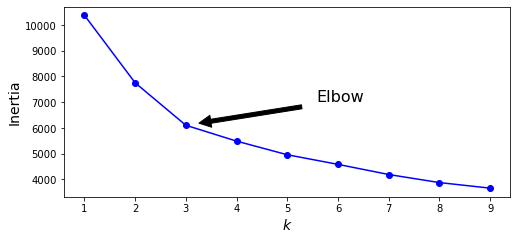

In [14]:
elbow_plot(inertias)

In [15]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

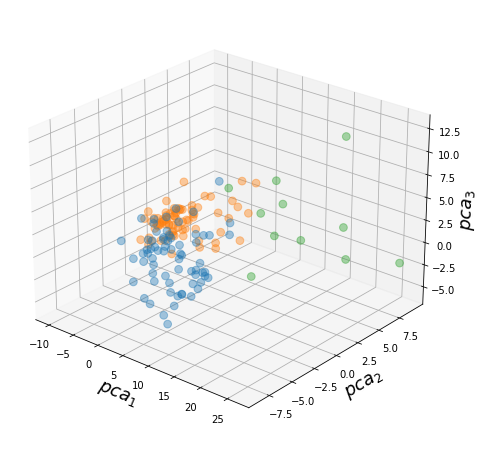

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for iter in range(3):
    ax.scatter(X[y_pred == iter, 0], X[y_pred == iter, 1],  X[y_pred == iter, 2], alpha=.4, s=60)

ax.view_init(25, -50)

ax.set_xlabel("$pca_1$", fontsize=18)
ax.set_ylabel("$pca_2$", fontsize=18)
ax.set_zlabel("$pca_3$", fontsize=18)
ax.grid(True)


## Hierarchical clustering

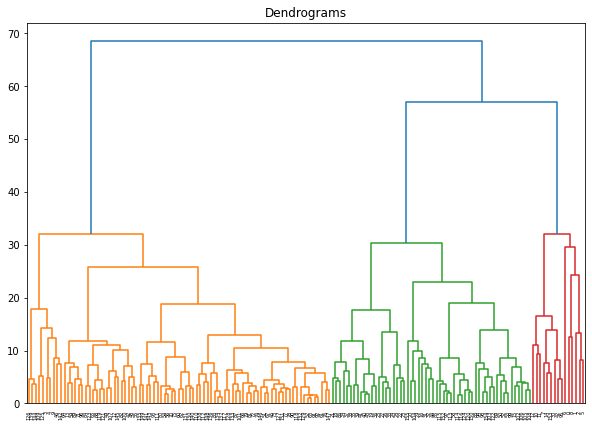

In [17]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize 

#X = sklearn.preprocessing.normalize(df_features)

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
dendro = shc.dendrogram(shc.linkage(X, method='ward'))

In [18]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', 
    linkage='ward', compute_full_tree=True, distance_threshold=40)  
lbl = cluster.fit_predict(X)

n = 1+np.amax(cluster.labels_)

print(f"Number of clusters = {n}")


Number of clusters = 3


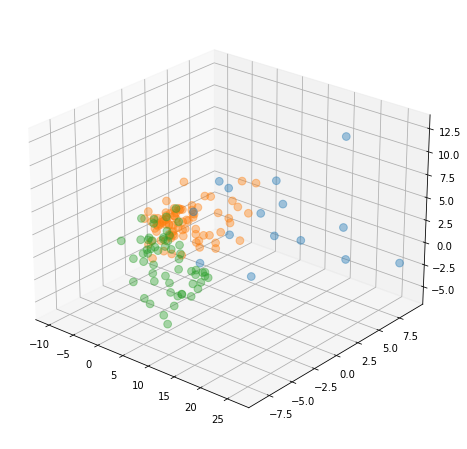

In [19]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for iter in range(n):
    ax.scatter(X[lbl == iter, 0], X[lbl == iter, 1],  X[lbl == iter, 2], alpha=.4, s=60)

ax.view_init(25, -50)